Assignment 19

In [175]:
import numpy as np
import cv2
import math
import sys
import time
import enum
import matplotlib.pyplot as plt
import networkx as nx



class Beacon:
    def __init__(self, location, id):
        self.x = location[0][0]
        self.y = location[1][0]
        self.z = location[2][0]
        self.id = id
    def __str__(self):
        return "Beacon {} at {}".format(self.id, self.GetLocation())
    def __repr__(self):
        return self.__str__()
    def GetLocation(self):
        return np.transpose(np.array([self.x, self.y, self.z], dtype=np.float64))
    def GetAugmentedLocation(self):
        return np.transpose(np.array([[self.x], [self.y], [self.z], [1] ], dtype=np.float64))
    def SetLocation(self, location):
        if location.shape == (3,1) or location.shape == (4,1):
            print(location[0][0], location[1,0], location[2,0])
            self.x = int(location[0][0])
            self.y = int(location[1][0])
            self.z = int(location[2][0])
        elif location.shape == (1,3) or location.shape == (1,4):
            self.x = int(location[0][0])
            self.y = int(location[0][1])
            self.z = int(location[0][2])
        else:
            print("Error: Invalid location shape")
            return
    def Copy(self):
        location = self.GetLocation()
        return Beacon([location[0][0], location[0,1], location[0,2]], self.id)


class Scanner:
    def __init__(self, location, id):
        self.id = id
        self.x = location[0]
        self.y = location[1]
        self.z = location[2]
        self.beacons = []
    def AddBeacon(self, beacon):
        self.beacons.append(beacon)
    def GetLocation(self):
        return np.transpose(np.array([self.x, self.y, self.z], dtype=np.float64))
    def GetAugmentedLocation(self):
        return np.transpose(np.array([[self.x], [self.y], [self.z], [1] ], dtype=np.float64))
    def SetLocation(self, location):
        if location.shape == (3,1) or location.shape == (4,1):
            self.x = location[0][0][0]
            self.y = location[1][0][0]
            self.z = location[2][0][0]
        elif location.shape == (1,3) or location.shape == (1,4):
            self.x = location[0][0]
            self.y = location[0][1]
            self.z = location[0][2]
        else:
            print("Error: Invalid location shape")
            return


def GetSensorData(dataset):
    data = []
    with open(dataset, 'r') as f:
        data = f.readlines()
    # strip the new line character
    
    data = [x.strip() for x in data]

    scanners = []
    sensor = {}
    beaconCount = 0
    scannerCount = 0
    for i in range(len(data)):
        #print(data[i])
        if (data[i].__contains__('scanner')):
            sensor = Scanner(np.array([[0], [0], [0]]), scannerCount)
            scannerCount += 1
            scanners.append(sensor)
        elif (data[i] == ''):
            continue
        else:
            location = data[i].split(',')
            beacon = Beacon(np.array([[int(location[0])], [int(location[1])], [int(location[2])]]), beaconCount)
            beaconCount += 1
            sensor.AddBeacon(beacon)

    return scanners

# create a distance map between each beacon in a scanner report
def CreateDistanceMaps(scanner):
    distanceMaps = []
    for i in range(len(scanner.beacons)):
        distanceMaps.append([scanner.beacons[i] , []])
        for j in range(len(scanner.beacons)):
            if (i == j):
                continue
            else:
                beacon1= scanner.beacons[i]
                beacon2 = scanner.beacons[j]
                distanceMaps[i][1].append([scanner.beacons[j], 
                    math.sqrt(
                          math.pow(beacon1.x - beacon2.x, 2) 
                          + math.pow(beacon1.y - beacon2.y, 2)
                          + math.pow(beacon1.z - beacon2.z, 2))])
        # Sort the distance map by distance
        distanceMaps[i][1].sort(key=lambda x: x[1])
    
    return distanceMaps

# check for each distancemap if an x amount of beacons are in a similar distance from each other
def CheckForBeacons(distanceMap, compairmap, x):
    count = 0
    for i in range(len(distanceMap)):
        for j in range(len(compairmap)):
            if (distanceMap[i][1] == compairmap[j][1]):
                #print("Found a match")
                count += 1
                if (count == x-1):
                    return True
    #print("match count: {}".format(count))
    return False


In [176]:
def FindConnections(DistanceMap):
    scannerConnections = []
    for i in range(len(DistanceMap)):
        for j in range(i+1, len(DistanceMap)):
            if (i == j):
                continue
            else:
                breakbool = False
                for k in range(len(DistanceMap[i][1])):
                    for l in range(len(DistanceMap[j][1])):
                        if( CheckForBeacons(DistanceMap[i][1][k][1], DistanceMap[j][1][l][1], 12)):
                            print(f'scanner {i} and scanner {j} have similar beacons : {DistanceMap[i][1][k][0].id} and {DistanceMap[j][1][l][0].id}')
                            breakbool = True
                            scannerConnections.append([i, j, k, l])
                    if (breakbool):
                        break
    return scannerConnections

def GraphConnections(scannerConnections):
    G = nx.Graph()
    nodeseen = {}
    for i in range(len(scannerConnections)):
        if (scannerConnections[i][0] not in nodeseen):
            nodeseen[scannerConnections[i][0]] = True
            G.add_node(scannerConnections[i][0])
        
    for i in range(len(scannerConnections)):
        G.add_edge(scannerConnections[i][0], scannerConnections[i][1])

    nx.draw(G, with_labels=True)
    plt.show()


In [177]:
def FindConnectionTo(scannerConnections, scanner):
    for i in range(len(scannerConnections)):
        if (scannerConnections[i][0] == scanner.id):
            return scannerConnections[i][1]
        elif (scannerConnections[i][1] == scanner.id):
            return scannerConnections[i][0]

def CreateTransformationMatrixArg(translationX = 0, translationY = 0, translationZ = 0):
    return np.array([
        [1, 0, 0, translationX],
        [0, 1, 0, translationY],
        [0, 0, 1, translationZ],
        [0, 0, 0, 1]])
def CreateTransformationMatrixVector(translation):
    return np.array([
        [1, 0, 0, translation[0][0]],
        [0, 1, 0, translation[0][1]],
        [0, 0, 1, translation[0][2]],
        [0, 0, 0, 1]])
def CreateRotationMatrixX(angle):
    return np.array([
        [1, 0, 0, 0],
        [0, math.cos(angle), -math.sin(angle), 0],
        [0, math.sin(angle), math.cos(angle), 0],
        [0, 0, 0, 1]])
def CreateRotationMatrixY(angle):
    return np.array([
        [math.cos(angle), 0, math.sin(angle), 0],
        [0, 1, 0, 0],
        [-math.sin(angle), 0, math.cos(angle), 0],
        [0, 0, 0, 1]])

def CreateRotationMatrixZ(angle):
    return np.array([
        [math.cos(angle), -math.sin(angle), 0, 0],
        [math.sin(angle), math.cos(angle), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])
def CreateInverseMatrix():
    return np.array([
        [-1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, -1, 0],
        [0, 0, 0, 1]])
    

# augment the rotation matrix to a translation matrix
def AugmentRotationMatrix(rotationMatrix):
    return np.array([
        [rotationMatrix[0][0], rotationMatrix[0][1], rotationMatrix[0][2], 0],
        [rotationMatrix[1][0], rotationMatrix[1][1], rotationMatrix[1][2], 0],
        [rotationMatrix[2][0], rotationMatrix[2][1], rotationMatrix[2][2], 0],
        [0, 0, 0, 1]])

def AugmentVector(vector):
    print(np.transpose(vector))
    return np.array([
        [vector[0][0]],[ vector[0][1]], [vector[0][2]], [1]], dtype=np.float64)
def DeAugmentVector(vector):
    return np.array([
        [vector[0][0]],[ vector[1][0]], [vector[2][0]]], dtype=np.float64)

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return AugmentRotationMatrix(rotation_matrix)

PossibleRotations = []
for x in range(0, 4):
    for y in range(0, 4):
        for z in range(0, 4):
            rotation = CreateRotationMatrixX(x * math.pi / 2).dot(CreateRotationMatrixY(y * math.pi / 2)).dot(CreateRotationMatrixZ(z * math.pi / 2))
            PossibleRotations.append(rotation)
def SearchRotations(vector1, vector2):
    for i in range(len(PossibleRotations)):
        #print(np.transpose(np.round(PossibleRotations[i].dot( vector1))),np.transpose(vector2))
        if (np.array_equal(np.round(PossibleRotations[i].dot( vector1)), vector2)):
            return PossibleRotations[i]
        else:
            continue


def FindTransformation(DistanceMap1, DistanceMap2):
    # get 2 beacons that are in the same distance from each other
    beaconOrigin = DistanceMap1[0]
    Transformation = CreateTransformationMatrixVector(-beaconOrigin.GetAugmentedLocation())
    beacon1 = Transformation.dot(np.transpose(DistanceMap1[1][0][0].GetAugmentedLocation()))
    beacon2 = Transformation.dot(np.transpose(DistanceMap1[1][1][0].GetAugmentedLocation()))

    #print(f'beacon1: {beacon1}')
    #print(f'beacon2: {beacon2}')
    #planeNormal = np.cross((beacon1)/np.linalg.norm(beacon1), beacon2/ np.linalg.norm(beacon2))
    

    beaconOrigin2 = DistanceMap2[0]
    Transformation = CreateTransformationMatrixVector(-beaconOrigin2.GetAugmentedLocation())
    beacon1_2 = Transformation.dot(np.transpose(DistanceMap2[1][0][0].GetAugmentedLocation()))

    #print(f'beacon1_2: {DistanceMap2[1][0][0].GetLocation()}')
    #print(f'beacon2_2: {DistanceMap2[1][1][0].GetLocation()}')
    #print(f'beacon1_2: {beacon1_2}')
    #print(f'beacon2_2: {beacon2_2}')


    Transformation = CreateTransformationMatrixVector(-beaconOrigin2.GetAugmentedLocation())
    Rotation = SearchRotations(beacon1_2, beacon1)
    ToOriginTransformation = CreateTransformationMatrixVector(beaconOrigin.GetAugmentedLocation())
    AllTransformations = ToOriginTransformation.dot(Rotation.dot(Transformation))

    Transformation = CreateTransformationMatrixVector(-beaconOrigin.GetAugmentedLocation())
    Rotation = SearchRotations(beacon1_2, beacon1)
    ToOriginTransformation = CreateTransformationMatrixVector(beaconOrigin2.GetAugmentedLocation())
    AllTransformationsBack = ToOriginTransformation.dot(Rotation.dot(Transformation))

    #print(f'beacon1: {np.transpose(beacon1)}')
    #print(f'beacon1_2: {np.transpose(beacon1_2)}')
    # apply the rotation to all beacons in the distance map 2
    # and check if the location of the beacon is the same as in map1
    #print(DistanceMap1[1])
    #print(DistanceMap2[1])
    

    CheckTransform = 0
    for i in range(len(DistanceMap2[1])):
        
        # Scanner frame
        #print(f'ScannerFrame DistanceMap2[1][{i}][0].location: {DistanceMap2[1][i][0].GetAugmentedLocation()}')
        
        transferred =  AllTransformations.dot(np.transpose(DistanceMap2[1][i][0].GetAugmentedLocation()))        
        #print(f'OriginFrame DistanceMap2[1][{i}][0] location: {np.transpose(np.round(transferred,0))}')
        transferred = np.round(transferred)
        Success = False
        found = False
        for j in range(len(DistanceMap1[1])):
            if (abs(DistanceMap1[1][j][1] - DistanceMap2[1][i][1]) < 0.001):
                found = True
                #print(f'DistanceMap1[1][{i}][0].location: {DistanceMap1[1][i][0].GetAugmentedLocation()}')
                #print(f'DistanceMap2[1][{j}][0].location: {np.transpose(transferred)}')
                if (DistanceMap1[1][j][0].x == transferred[0][0] 
                and DistanceMap1[1][j][0].y == transferred[1][0] 
                and DistanceMap1[1][j][0].z == transferred[2][0]):
                    Success = True
                    #print(f'{i} {j} {Success}')
                    break
        if (found):
            if (Success):
                CheckTransform += 1
    #print(f'CheckTransform: {CheckTransform}')
    if (CheckTransform >= 11):
        return AllTransformations, AllTransformationsBack
    else:
        return None, None

def AddBeaconsToScanner(scanner1,beacons, Transformation):
    for i in range(len(beacons)):
        newBeacon = beacons[i].Copy()
        newBeacon.SetLocation(np.round(Transformation.dot(np.transpose(newBeacon.GetAugmentedLocation()))))
        for j in range(len(scanner1.beacons)):
            if (newBeacon.x == scanner1.beacons[j].x and newBeacon.y == scanner1.beacons[j].y and newBeacon.z == scanner1.beacons[j].z):
                break
            else:
                scanner1.beacons.append(newBeacon)
                break
    return scanner1

def AddToOrginScanner(scanners, transformations, connections, currentIndex=0, visitList={}): 
    # in connections get the connections where the [0] is the currentIndex
    print(f'currentIndex: {currentIndex}')
    print(f'visits: {visitList}')
    if (currentIndex in visitList):
        return
    visitList[currentIndex] = True
    print(f'currentIndex: {currentIndex}')
    connectionlist = []
    for i in range(len(connections)):
        if (connections[i][0] == currentIndex or connections[i][1] == currentIndex):
            connectionlist.append(connections[i])

    for connection in connectionlist:
        if (connection[0] == currentIndex):
            if (connection[1] not in visitList):
                AddToOrginScanner(scanners, transformations, connections, connection[1], visitList)
                AddBeaconsToScanner(scanners[connection[0]], scanners[connection[1]].beacons, transformations[(connection[1],connection[0])])
        else:
            if (connection[0] not in visitList):
                AddToOrginScanner(scanners, transformations, connections, connection[0], visitList)
                AddBeaconsToScanner(scanners[connection[1]], scanners[connection[0]].beacons, transformations[(connection[0],connection[1])])
    print(f'{currentIndex} done')

def TransformBeacons(scanners):
    DistanceMaps = []
    for i in range(len(scanners)):
        DistanceMaps.append([scanners[i] ,CreateDistanceMaps(scanners[i])])

    scannerConnections = FindConnections(DistanceMaps)
    transforms= {}
    GraphConnections(scannerConnections)
    for connections in scannerConnections:
        i , j , k , l = connections
        transform, transformBack = FindTransformation(DistanceMaps[i][1][k], DistanceMaps[j][1][l])
        if (transform is None):
            print(f'No transformation found between {i} and {j}')
        else:
            transforms[(j,i)] = np.round(transform)
            transforms[(i,j)] = np.round(transformBack)
            print(f'Transformation found between {i} and {j}')
            print(transforms[(i,j)])
            print(transforms[(j,i)])

            
    
    # create transformation matrix to origin scanner 0
    """
    while (True):
        for i in range(len(scanners)):
            for j in range(len(scanners)):
                if (i == j):
                    continue
                for k in range(len(scanners)):
                    
                    if not (i,k) in transforms and (i,j) in transforms and (j,k) in transforms and k!= i :
                        transform = transforms[(j,k)].dot(transforms[(i,j)])
                        print (f'Transformation between {k} <-> {j} <-> {i}')
                        #print(transforms[(j,k)].dot(transforms[(i,j)]))
                        #print(transforms[(j,k)].dot(transforms[(j,i)]))
                        #print(transforms[(k,j)].dot(transforms[(i,j)]))
                        #print(transforms[(k,j)].dot(transforms[(j,i)]))
                        #print(transforms[(i,j)].dot(transforms[(j,k)]))
                        #print(transforms[(i,j)].dot(transforms[(k,j)]))
                        #print(transforms[(j,i)].dot(transforms[(j,k)]))
                        #print(transforms[(j,i)].dot(transforms[(k,j)]))
                        transforms[(i,k)] = np.round(transform)
                        transforms[(k,i)] = np.round(np.linalg.inv(transform))
        count = 0
        for i in range(len(scanners)):
            if (i,0) in transforms:
                count += 1
        print(count)
        if (count == len(scanners)-1):
            break
    """
    
    print(" start transformations")
    AddToOrginScanner(scanners, transforms, scannerConnections, 0, {})

    return scanners[0]
       
    
    

In [178]:
if(False):
    scanners = GetSensorData('./data/aoc19_test2.txt')

    scanner = TransformBeacons(scanners)
    scanner.beacons.sort(key=lambda x: x.x)
    print(scanner.beacons)
    print(len(scanner.beacons))
    scannersExpected = GetSensorData('./data/aoc19_Expected.txt')

    #remove duplicates
    beaconlist = {}
    for i in range(len(scanner.beacons)):
        x = scanner.beacons[i].x
        y = scanner.beacons[i].y
        z = scanner.beacons[i].z
        beaconlist[f"{x},{y},{z}"] = scanner.beacons[i]
    print(beaconlist)
    print(len(beaconlist))

scanner 0 and scanner 17 have similar beacons : 2 and 445
scanner 1 and scanner 7 have similar beacons : 29 and 184
scanner 1 and scanner 12 have similar beacons : 28 and 322
scanner 1 and scanner 23 have similar beacons : 25 and 612
scanner 1 and scanner 36 have similar beacons : 26 and 937
scanner 2 and scanner 25 have similar beacons : 52 and 673
scanner 3 and scanner 23 have similar beacons : 79 and 614
scanner 4 and scanner 21 have similar beacons : 103 and 557
scanner 4 and scanner 25 have similar beacons : 103 and 649
scanner 5 and scanner 36 have similar beacons : 129 and 956
scanner 6 and scanner 11 have similar beacons : 154 and 297
scanner 6 and scanner 13 have similar beacons : 157 and 351
scanner 7 and scanner 10 have similar beacons : 180 and 283
scanner 7 and scanner 11 have similar beacons : 181 and 299
scanner 8 and scanner 19 have similar beacons : 206 and 492
scanner 8 and scanner 29 have similar beacons : 206 and 764
scanner 9 and scanner 17 have similar beacons : 2

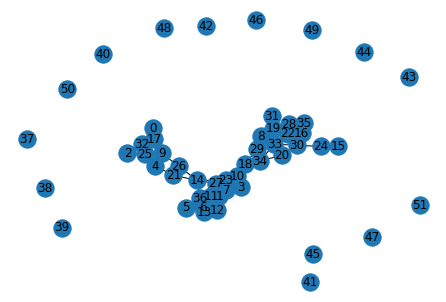

Transformation found between 0 and 17
[[-0.000e+00 -0.000e+00  1.000e+00  1.068e+03]
 [ 0.000e+00 -1.000e+00  0.000e+00 -5.700e+01]
 [ 1.000e+00  0.000e+00  0.000e+00 -1.700e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[-0.000e+00 -0.000e+00  1.000e+00  1.700e+01]
 [ 0.000e+00 -1.000e+00  0.000e+00 -5.700e+01]
 [ 1.000e+00  0.000e+00  0.000e+00 -1.068e+03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
Transformation found between 1 and 7
[[ 1.000e+00  0.000e+00  0.000e+00 -1.390e+02]
 [ 0.000e+00 -1.000e+00  0.000e+00 -1.056e+03]
 [ 0.000e+00  0.000e+00 -1.000e+00  9.300e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[ 1.000e+00  0.000e+00  0.000e+00  1.390e+02]
 [ 0.000e+00 -1.000e+00  0.000e+00 -1.056e+03]
 [ 0.000e+00  0.000e+00 -1.000e+00  9.300e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
Transformation found between 1 and 12
[[   1.    0.    0. -122.]
 [  -0.   -0.    1. -347.]
 [   0.   -1.   -0.  661.]
 [   0.    0.    0.    1.]]
[[ 1.000e+00  0.000e+0

In [179]:
if (True):
    scanners = GetSensorData('./data/aoc19.txt')

    scanner = TransformBeacons(scanners)
    
    scanner.beacons.sort(key=lambda x: x.x)
    print(scanner.beacons)
    print(len(scanner.beacons))
    beaconlist = {}
    for i in range(len(scanner.beacons)):
        x = scanner.beacons[i].x
        y = scanner.beacons[i].y
        z = scanner.beacons[i].z
        beaconlist[f"{x},{y},{z}"] = scanner.beacons[i]
    print(beaconlist)
    print(len(beaconlist))